# Test for Sample and Bubble MST

## Importing and definitions

In [12]:
#importing libraries
import utils as u
import numpy as np
import pandas as pd
import pynndescent
from random import seed
from random import sample
from time import monotonic
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances 
from scipy.sparse import lil_matrix
from scipy.spatial import distance

In [13]:
#definition of method that builds the Core-SG
def buildCoreSG(knn, mst):
    
    #Building Core-SG
    CoreSG = [[nn for nn in nnlist] for nnlist in knn]
    
    #Adding edges 
    rows,cols = mst.nonzero()
    for row,col in zip(rows,cols):
        CoreSG[row] = CoreSG[row] + [(mst[row,col], col)]
        CoreSG[col] = CoreSG[col] + [(mst[row,col], row)]
        
    #Eliminating duplicates and sorting
    for i in range(len(CoreSG)):
        edges_set = set(CoreSG[i])
        CoreSG[i] = list(edges_set)
        CoreSG[i].sort()
    
    return(CoreSG)

In [14]:
#definition of method that merges two graphs, using index to keep correspondence of points
def merge_edges(graph1,graph2,index):
    
    #converting graph 2 labels into graph 1 labels 
    converted_graph2 = [[nn for nn in nnlist] for nnlist in graph2] 
    for i in range(len(graph2)):
        for j in range(len(graph2[i])): 
            converted_graph2[i][j] = (graph2[i][j][0],index[graph2[i][j][1]])
    
    #concatenate graph2 in graph1, delete repetitions, sort edges
    final_graph = [[nn for nn in nnlist] for nnlist in graph1] 
    for i in range(len(index)):
        final_graph[index[i]] = final_graph[index[i]] + converted_graph2[i]
        edges_set = set(final_graph[index[i]])
        final_graph[index[i]] = list(edges_set)
        final_graph[index[i]].sort()
    
    return(final_graph)

In [15]:
#definition of method to truncates/pads a float f to n decimal places without rounding
def truncate(f, n):
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [16]:
#definition of method to compare edges in terms of absolute value
def compare_edges(graph1,graph2):
    
    #extracting edges
    edges1 = set(u.get_edges(graph1.toarray()))
    edges2 = set(u.get_edges(graph2.toarray()))
    dif1 = (edges1 - edges2)
    dif2 = (edges2 - edges1)
    
    #extracting weights  
    weights1 = [max(graph1[i,j],graph1[j,i]) for (i,j) in dif1]
    weights2 = [max(graph2[i,j],graph2[j,i]) for (i,j) in dif2]
    
    #sorting 
    weights1.sort()
    weights2.sort()
    
    #counting diffrent edges
    total = abs(len(dif1)-len(dif2))    
    for i in range(min(len(dif1),len(dif2))):
        if truncate(weights1[i],5) != truncate(weights2[i],5):
            total = total+1
            
    return total

In [17]:
#definition of method that calculates mutual reachability distances
def calculate_mrd(sorted_distance_matrix, mpts):

    #calculating core distances
    core_dist = [sorted_distance_matrix[i][mpts-2][0] for i in range(len(sorted_distance_matrix))]
    
    #calculating mrd wrt mpts 
    mrd_dist = [[(max(sorted_distance_matrix[i][j][0],core_dist[i], core_dist[j]),sorted_distance_matrix[i][j][1]) for j in range(len(sorted_distance_matrix[i]))] for i in range(len(sorted_distance_matrix))]
    
    #sorting distances
    for i in range(len(mrd_dist)):
        mrd_dist[i].sort()

    return (mrd_dist, core_dist)

In [18]:
#definition of weighted inverted proportional sample
def roulette(weights, sample_size):
    
    chosen = set()
    compl_prop = np.zeros(len(weights))
    prob = np.zeros(len(weights))
    sum_prob = np.zeros(len(weights))
    
    sum_weights = sum(weights)                 
    for i in range(len(weights)):
        compl_prop[i] = sum_weights/weights[i]
 
    sum_prop = sum(compl_prop)
    for i in range(len(compl_prop)):
        prob[i] = compl_prop[i]/sum_prop

    sum_prob[0] = prob[0]
    for i in range(len(prob)-1):
        sum_prob[i+1] = sum_prob[i] + prob[i+1]

    while len(chosen) < sample_size:
        draw = np.random.uniform(0, 1)
        i = 0
        while sum_prob[i] < draw:
            i = i + 1
        chosen.add(i) 
        
    return list(chosen)

In [19]:
#definition of bubble sampling method
def bubble_sampling(dataset, sample_index):
    
    #extracting sample
    sample_data = dataset[sample_index,:]
    
    #calculating distances
    dist = euclidean_distances(dataset, sample_data)
    
    #calculating labels
    labels = np.array([dist[i].argmin() for i in range(N)])
    
    #calculating centroids
    centroids = [None] * sample_size
    for i in range(sample_size):
        subset = dataset[np.where(labels == i)[0]]
        centroids[i] = subset.mean(0)
    
    #Calculating MST of the centroids
    sorted_dist_s = u.get_sorted_dist_matrix(centroids)
    mst_centroids = u.get_mst(u.to_adj_m(sorted_dist_s))
    
    return centroids, labels, mst_centroids

In [20]:
#definition of edge improvement method
def edge_improvement(dataset, centroids, labels, mst):
    
    #extracting edges
    edges = set(u.get_edges(mst.toarray()))
    
    newedges = lil_matrix((len(dataset),len(dataset))) 
                
    for edge in edges:
        pos1 = np.where(labels == edge[0])[0]
        pos2 = np.where(labels == edge[1])[0]
        subset1 = dataset[pos1]
        subset2 = dataset[pos2]
        dist1 = euclidean_distances(subset1, [centroids[edge[0]]])
        dist2 = euclidean_distances(subset2, [centroids[edge[1]]])
        index1 = pos1[dist1.argmin()]
        index2 = pos2[dist2.argmin()]
        newedges[index1,index2] = distance.euclidean(dataset[index1],dataset[index2])
        newedges[index2,index1] = newedges[index1,index2]
    
    return newedges

In [21]:
#definition of method to add bubble edges to knn
def merge_bubbles(knn,bubble_edges):
    
    #extracting edges
    edges = u.get_edges(bubble_edges.toarray())
    
    for edge in edges:
        knn[edge[0]] = knn[edge[0]] + [(bubble_edges[edge[0],edge[1]],edge[1])]
        edges_set = set(knn[edge[0]])
        knn[edge[0]] = list(edges_set)
        knn[edge[0]].sort()
        knn[edge[1]] = knn[edge[1]] + [(bubble_edges[edge[1],edge[0]],edge[0])] 
        edges_set = set(knn[edge[1]])
        knn[edge[1]] = list(edges_set)
        knn[edge[1]].sort()   
        
    return knn

## Dataset and parameters

In [22]:
#loading datasets
files = {
1:'Datasets/blobs_seed_1227_size_1000_centers_4.csv',
2:'Datasets/blobs_seed_1227_size_10000_centers_5.csv',
3:'Datasets/blobs_seed_1227_size_100000_centers_6.csv',
4:'Datasets/blobs_seed_1227_size_1000000_centers_7.csv',
5:'Datasets/blobs_size_100_centers_10_outliers_0.csv',
6:'Datasets/blobs_size_1000_centers_4_outliers_100.csv',
7:'Datasets/blobs_size_1000_centers_7_outliers_50.csv',
8:'Datasets/blobs_size_1000_centers_10_outliers_0.csv',
9:'Datasets/blobs_size_1000_centers_10_outliers_50.csv',
10:'Datasets/blobs_size_1000_centers_10_outliers_100.csv',
11:'Datasets/blobs_size_1000_centers_10_outliers_150.csv',
12:'Datasets/blobs_size_2000_centers_20_outliers_0.csv',
13:'Datasets/blobs_size_10000_centers_7_outliers_500.csv',
14:'Datasets/blobs_size_10000_centers_7_outliers_1000.csv',
15:'Datasets/blobs_size_10000_centers_10_outliers_0.csv',
16:'Datasets/blobs_size_10000_centers_10_outliers_1000.csv',
17:'Datasets/circles_seed_1227_size_1000.csv',
18:'Datasets/moons_size_1000_outliers_0.csv',
19:'Datasets/moons_size_1000_outliers_100.csv',
20:'Datasets/swissroll_seed_1227_size_1000.csv',
21:'Datasets/swissroll_seed_1227_size_10000.csv',
22:'Datasets/swissroll_seed_1227_size_100000.csv',
23:'Datasets/swissroll_seed_1227_size_1000000.csv',
24:'Datasets/test_blobs_seed_231_size_1000_centers_4.csv',
25:'Datasets/test_blobs_seed_1227_size_1000_centers_4.csv',
26:'Datasets/test_blobs_size_1000_centers_4_outliers_100.csv',
27:'Datasets/horseshoe.csv',
28:'Datasets/blobs_size_2000_centers_10_outliers_20.csv',
29:'Datasets/badmoons.csv',
30:'Datasets/blobs_size_5000_centers_10_outliers_0.csv'
}
dsname = files[30]
dataset = pd.read_csv(dsname, header=None).values
#defining k
k = 10
mpts = k 
#Defining size and sample
N = len(dataset)
sample_prop = 0.05
sample_size = int(N * sample_prop)

## Main code

### Sampling

In [23]:
#Sampling
seed(monotonic())
sequence = range(N)
subset = sample(sequence, sample_size)
sample_data = dataset[subset,:]

#Calculating MST and Core-SG of the sample
sorted_dist_s = u.get_sorted_dist_matrix(sample_data)

#Calculating Sample MST
mst_S = u.get_mst(u.to_adj_m(sorted_dist_s))

#Calculating Bubble
centroids, labels, mst = bubble_sampling(dataset, subset)
bubble_edges = edge_improvement(dataset, centroids, labels, mst)

### Calculating KNN

In [24]:
#Calculating approximated KNN with
index = pynndescent.NNDescent(dataset, n_neighbors = k, verbose=True)
#Convert pyNNDescent to Igor's Structure
knndescent = u.convert_pynndescent_output(index.neighbor_graph)

#Enhance knndescent with MST of the sample
emptybase = [ [] for i in range(sample_size)] 
converted_mst_S = buildCoreSG(emptybase, mst_S)
knnMST = merge_edges(knndescent, converted_mst_S, subset)

#Enhance knndescent with MST of bubbles with improvement
knnBubble = merge_bubbles(knndescent,bubble_edges)

#Calculate and build exact 
sorted_dist_m = u.get_sorted_dist_matrix(dataset)

Wed Sep  8 17:55:23 2021 Building RP forest with 13 trees
Wed Sep  8 17:55:23 2021 NN descent for 12 iterations
[LOW] 	 1  /  12
[LOW] 	 2  /  12
	Stopping threshold met -- exiting after 2 iterations


### Calculating densities estimates

In [25]:
#calculate mrd and core true distances
mpts = k
mrd_dist , core_dist = calculate_mrd(sorted_dist_m, mpts)

#calculate approximatted mrd and core distances with knn
knn_mrd_dist , knn_core_dist = calculate_mrd(knndescent, mpts)

### Calculating MSTs and Plotting

In [26]:
#calculate the MSF of the knn
mst_knn = u.get_mst(u.to_adj_m(knndescent))
    
#calculate the MSF of the knn + MST
mst_knn_mst = u.get_mst(u.to_adj_m(knnMST))

#calculate the MSF of the knn + bubbles
mst_knn_Bubble = u.get_mst(u.to_adj_m(knnBubble))

#calculte real mst
real_mst = u.get_mst(u.to_adj_m(sorted_dist_m))

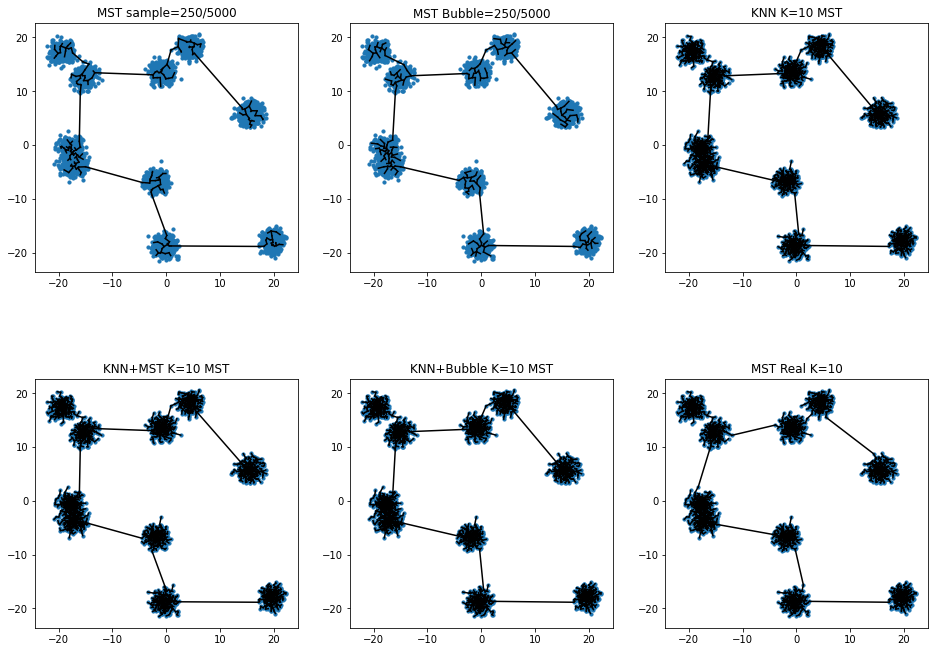

In [27]:
#defining size
plt.figure(figsize=(16,12))

#building sampling
emptybase = [ [] for i in range(N)] 
sample_edges = merge_edges(emptybase, converted_mst_S, subset)  
sample_MST = u.get_mst(u.to_adj_m(sample_edges))
ax = plt.subplot(2,3,1)
ax.set_aspect('equal')
u.plot_edges(dataset, sample_MST.toarray())
u.plot_dataset(dataset)
plt.title(f"MST sample={sample_size}/{N}")

#building sampling
emptybase = [ [] for i in range(N)] 
bubble_edges = merge_bubbles(emptybase,bubble_edges)  
bubble_MST = u.get_mst(u.to_adj_m(bubble_edges))
ax = plt.subplot(2,3,2)
ax.set_aspect('equal')
u.plot_edges(dataset, bubble_MST.toarray())
u.plot_dataset(dataset)
plt.title(f"MST Bubble={sample_size}/{N}")

ax = plt.subplot(2,3,3)
ax.set_aspect('equal')
u.plot_edges(dataset, mst_knn.toarray())
u.plot_dataset(dataset)
plt.title(f"KNN K={k} MST")
        
ax = plt.subplot(2,3,4)
ax.set_aspect('equal')
u.plot_edges(dataset, mst_knn_mst.toarray())
u.plot_dataset(dataset)
plt.title(f"KNN+MST K={k} MST")

ax = plt.subplot(2,3,5)
ax.set_aspect('equal')
u.plot_edges(dataset, mst_knn_Bubble.toarray())
u.plot_dataset(dataset)
plt.title(f"KNN+Bubble K={k} MST")

ax = plt.subplot(2,3,6)
ax.set_aspect('equal')
u.plot_edges(dataset, real_mst.toarray())
u.plot_dataset(dataset)
plt.title(f"MST Real K={k}")

plt.show()

In [28]:
#extracting edges
mst_knn_edges = set(u.get_edges(mst_knn.toarray()))
mst_knn_mst_edges = set(u.get_edges(mst_knn_mst.toarray()))
mst_bubbles_mst_edges = set(u.get_edges(mst_knn_Bubble.toarray()))
real_mst_edges = set(u.get_edges(real_mst.toarray()))    
#printing MST analysis
print(f"k = {k}")
print(f"Number of MST edges: {len(real_mst_edges)}")
print("---------------------------------------------------\n")
print(f"Number of KNN edges that are not in the MST = {len(mst_knn_edges - real_mst_edges)}/{len(mst_knn_edges)}")
print(f"Number of KNN + MST edges that are not in the MST = {len(mst_knn_mst_edges - real_mst_edges)}/{len(mst_knn_mst_edges)}")
print(f"Number of KNN + MST Bubble edges that are not in the MST = {len(mst_bubbles_mst_edges - real_mst_edges)}/{len(mst_bubbles_mst_edges)}")
print("\n---------------------------------------------------\n")
#calculating sum of edges of the MSF
print(f"Sum of MSF from KNN edges and  = {mst_knn.sum()} (Proportion to real MST = {mst_knn.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + MST = {mst_knn_mst.sum()} (Proportion to real MST = {mst_knn_mst.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + MST Bubbles = {mst_knn_Bubble.sum()} (Proportion to real MST = {mst_knn_Bubble.sum()/real_mst.sum()})")
print(f"Sum of MST = {real_mst.sum()}")

k = 10
Number of MST edges: 4999
---------------------------------------------------

Number of KNN edges that are not in the MST = 7/4999
Number of KNN + MST edges that are not in the MST = 7/4999
Number of KNN + MST Bubble edges that are not in the MST = 7/4999

---------------------------------------------------

Sum of MSF from KNN edges and  = 715.3121914215527 (Proportion to real MST = 1.0135317062131897)
Sum of MSF from KNN + MST = 716.8793517581635 (Proportion to real MST = 1.0157522285374605)
Sum of MSF from KNN + MST Bubbles = 715.3121914215527 (Proportion to real MST = 1.0135317062131897)
Sum of MST = 705.762027015553


## Test over density estimates (Mutual Reachability Distances)

In [29]:
#calculate approximatted mrd and core distances with knn + mst
mst_mrd_dist , mst_core_dist = calculate_mrd(knnMST, mpts)

In [30]:
#calculate the MSF of the knn
mst_knn = u.get_mst(u.to_adj_m(knn_mrd_dist))
    
#calculate the MSF of the knn + MST
mst_knn_mst = u.get_mst(u.to_adj_m(mst_mrd_dist))

#calculte real mst
real_mst = u.get_mst(u.to_adj_m(mrd_dist))

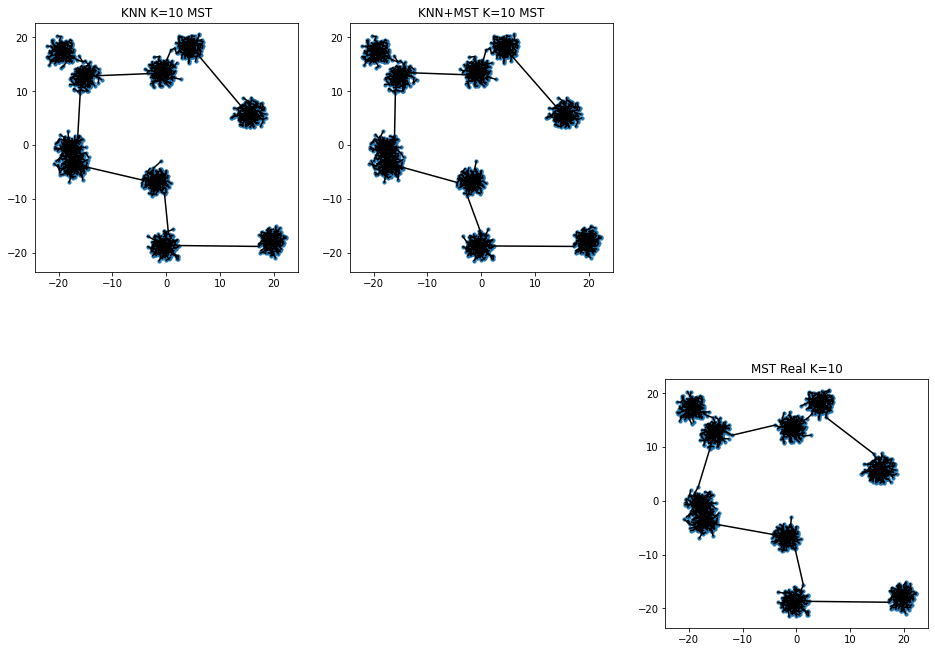

In [31]:
#defining size
plt.figure(figsize=(16,12))

#plotting   
ax = plt.subplot(2,3,1)
ax.set_aspect('equal')
u.plot_edges(dataset, mst_knn.toarray())
u.plot_dataset(dataset)
plt.title(f"KNN K={k} MST")
        
ax = plt.subplot(2,3,2)
ax.set_aspect('equal')
u.plot_edges(dataset, mst_knn_mst.toarray())
u.plot_dataset(dataset)
plt.title(f"KNN+MST K={k} MST")

        
ax = plt.subplot(2,3,6)
ax.set_aspect('equal')
u.plot_edges(dataset, real_mst.toarray())
u.plot_dataset(dataset)
plt.title(f"MST Real K={k}")
        
plt.show()

In [32]:
#extracting edges
mst_knn_edges = set(u.get_edges(mst_knn.toarray()))
mst_knn_mst_edges = set(u.get_edges(mst_knn_mst.toarray()))
mst_knn_core_edges = set(u.get_edges(mst_knn_core.toarray()))  
mst_knn_mst_edgesPS = set(u.get_edges(mst_knn_mstPS.toarray()))
mst_knn_core_edgesPS = set(u.get_edges(mst_knn_corePS.toarray())) 
real_mst_edges = set(u.get_edges(real_mst.toarray()))    
#printing MST analysis
print(f"k = {k}")
print(f"Number of MST edges: {len(real_mst_edges)}")
print("---------------------------------------------------\n")
print(f"Number of KNN edges that are not in the MST = {len(mst_knn_edges - real_mst_edges)}/{len(mst_knn_edges)}")
print(f"Number of KNN + MST edges that are not in the MST = {len(mst_knn_mst_edges - real_mst_edges)}/{len(mst_knn_mst_edges)}")
print(f"Number of KNN + CoreSG edges that are not in the MST = {len(mst_knn_core_edges - real_mst_edges)}/{len(mst_knn_core_edges)}")
print(f"Number of KNN + MST PS edges that are not in the MST = {len(mst_knn_mst_edgesPS - real_mst_edges)}/{len(mst_knn_mst_edgesPS)}")
print(f"Number of KNN + CoreSG PS edges that are not in the MST = {len(mst_knn_core_edgesPS - real_mst_edges)}/{len(mst_knn_core_edgesPS)}")
print(f"Number of (KNN + CoreSG) - (KNN + MST) edges = {len(mst_knn_core_edges - mst_knn_mst_edges)}")
print(f"Number of (KNN + CoreSG) - (KNN + MST) PS edges = {len(mst_knn_core_edgesPS - mst_knn_mst_edgesPS)}")
print("\n---------------------------------------------------\n")
#comparing MSF using weight sorted method
print(f"Weighting comparison of MSF from KNN edges and  = {compare_edges(mst_knn,real_mst)}")
print(f"Weighting comparison of MSF from KNN + MST = {compare_edges(mst_knn_mst,real_mst)}")
print(f"Weighting comparison of MSF from KNN + CoreSG = {compare_edges(mst_knn_core,real_mst)}")
print(f"Weighting comparison of MSF from KNN + MST PS = {compare_edges(mst_knn_mstPS,real_mst)}")
print(f"Weighting comparison of MSF from KNN + CoreSG PS = {compare_edges(mst_knn_corePS,real_mst)}")
print("\n---------------------------------------------------\n")
#calculating sum of edges of the MSF
print(f"Sum of MSF from KNN edges and  = {mst_knn.sum()} (Proportion to real MST = {mst_knn.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + MST = {mst_knn_mst.sum()} (Proportion to real MST = {mst_knn_mst.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + CoreSG = {mst_knn_core.sum()} (Proportion to real MST = {mst_knn_core.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + MST PS = {mst_knn_mstPS.sum()} (Proportion to real MST = {mst_knn_mstPS.sum()/real_mst.sum()})")
print(f"Sum of MSF from KNN + CoreSG PS = {mst_knn_corePS.sum()} (Proportion to real MST = {mst_knn_corePS.sum()/real_mst.sum()})")
print(f"Sum of MST = {real_mst.sum()}")

NameError: name 'mst_knn_core' is not defined

## Setup and Install

In [ ]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install -e ~/notebook/pynndescent-master/
#!{sys.executable} -m pip install pynndescent
#!{sys.executable} -m pip uninstall -y pynndescent